In [2]:
# Importando bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import datetime

In [3]:
# Funções úteis

def dt_to_unix_ns(date):
    return datetime.datetime.timestamp(date) * 1000 * 1000

def unix_ns_to_dt(x):
    return pd.to_datetime(x, unit='us', origin='unix')

def kb_to_mb(x):
    return x / 1000

def extract_metric(api_url, metric, filename):
    response = requests.get(f'{api_url}/api/metrics?metric={metric}')

    with open(filename, mode='wb') as f:
        f.write(response.content)

def extract_node(api_url):
    response = requests.get(f'{api_url}/api/health')

    data = response.json()

    return data.get('node', 'no-node')

In [4]:
# Extraindo dados

metrics = ['vm.memory.total', 'events.total']
api_urls = ['http://localhost:4001', 'http://localhost:4002', 'http://localhost:4003']

nodes = []

for api_url in api_urls:
    node = extract_node(api_url)

    nodes.append(node)

    for metric in metrics:
        extract_metric(api_url=api_url, metric=metric, filename=f'data/{node}-{metric}.csv')

start_date  = datetime.datetime(2022, 5, 15, 17, 00)
end_data  = datetime.datetime(2022, 5, 15, 17, 30)

start_date_in_unix_ns = dt_to_unix_ns(start_date)
end_date_in_unix_ns = dt_to_unix_ns(end_data)

In [5]:
# Sandbox
node = nodes[0]
metric = 'vm.memory.total'

data = pd.read_csv(f'data/{node}-{metric}.csv')

data.columns = ['node', 'metric_name', 'label', 'measurement', 'time']

data = data[(data['time'] >= start_date_in_unix_ns) & (data['time'] <= end_date_in_unix_ns)]

data['time'] = data['time'].apply(unix_ns_to_dt)
data['measurement'] = data['measurement'].apply(kb_to_mb)

data = data.set_index('time')

data.head()

,node,metric_name,label,measurement
time,,,,
2022-05-15 20:29:55.215962,fogex@5a8678082711,vm.memory.total,NaN,87.850696
2022-05-15 20:29:50.214606,fogex@5a8678082711,vm.memory.total,NaN,87.691936
2022-05-15 20:29:45.213993,fogex@5a8678082711,vm.memory.total,NaN,88.044984
2022-05-15 20:29:40.212657,fogex@5a8678082711,vm.memory.total,NaN,86.590888
2022-05-15 20:29:35.212116,fogex@5a8678082711,vm.memory.total,NaN,86.557112


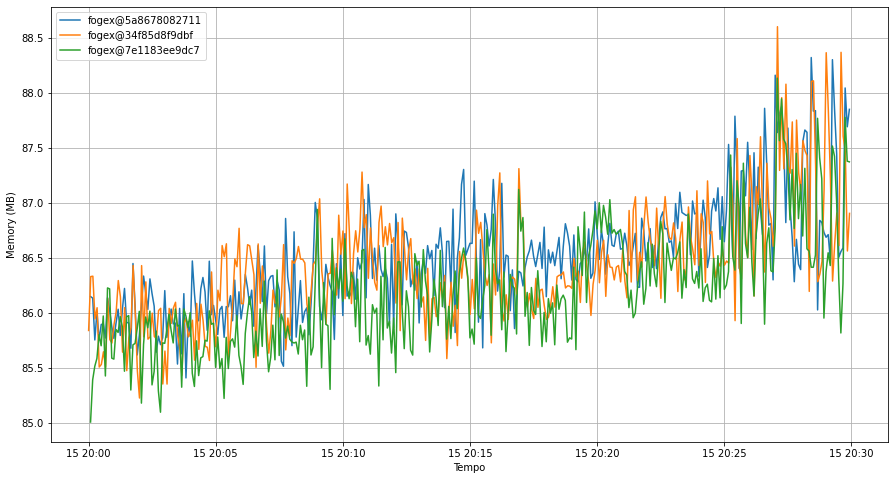

In [6]:
# Plotando a métrica vm.memory.total
datas = []
metric = 'vm.memory.total'

for node in nodes:
    data = pd.read_csv(f'data/{node}-{metric}.csv')

    data.columns = ['node', 'metric_name', 'label', 'measurement', 'time']

    data = data[(data['time'] >= start_date_in_unix_ns) & (data['time'] <= end_date_in_unix_ns)]

    data['time'] = data['time'].apply(unix_ns_to_dt)
    data['measurement'] = data['measurement'].apply(kb_to_mb)

    data = data.set_index('time')

    datas.append((node, data))

fig = plt.figure(figsize=(15, 8))

plt.ylabel('Memory (MB)')
plt.xlabel('Tempo')

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

plt.legend()
plt.grid()

plt.savefig(f'output/{metric}.png')